<a href="https://colab.research.google.com/github/sv650s/springboard/blob/master/aic-8_2_10_clustering-mini-project/Mini_Project_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [0]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
# sns.set_style("whitegrid")
# sns.set_context("poster")
# use default seaborn formatting
sns.set()

In [40]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# don't need this since I'm going to copy from drive folder directly
# !cp drive/'My Drive'/Springboard/data/WineKMC.xlsx .
# df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [42]:
# load excel from google drive directly
df_offers = pd.read_excel("drive/My Drive/Springboard/data/WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [43]:
df_transactions = pd.read_excel("drive/My Drive/Springboard/data/WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [44]:
#your turn
import numpy as np
merged_df = df_transactions.merge(df_offers["offer_id"], how="outer", on="offer_id")
offer_df =  merged_df.pivot_table(values=["n"], index=["customer_name"], columns=["offer_id"], 
                                      fill_value=0).reset_index()
offer_df.head()



customer_name  n                          ...                              
offer_id                1  2  3  4  5  6  7  8  9  ... 23 24 25 26 27 28 29 30 31 32
0                Adams  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  1  1  0  0
1                Allen  0  0  0  0  0  0  0  0  1  ...  0  0  0  0  1  0  0  0  0  0
2             Anderson  0  0  0  0  0  0  0  0  0  ...  0  1  0  1  0  0  0  0  0  0
3               Bailey  0  0  0  0  0  0  1  0  0  ...  0  0  0  0  0  0  0  1  0  0
4                Baker  0  0  0  0  0  0  1  0  0  ...  0  0  0  0  0  0  0  0  1  0

[5 rows x 33 columns]

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

**Answer**



**What values of  𝑆𝑆  do you believe represent better clusterings? Why?**

Smaller values for SS represents better clustering as the mean squared error for each point to it's centroid is minimized


**Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums)**


In [0]:
from sklearn.cluster import KMeans

x_cols = offer_df.drop("customer_name", axis='columns')
ss = {}
predictions = {}
centers_km = {}

for k in range(2, 11):
  km = KMeans(n_clusters=k, random_state=1)
  predict = km.fit_predict(x_cols)
  # put the results in lists so it's easier to plot later
  ss[k] = km.inertia_
  centers_km[k] = km.cluster_centers_
  predictions[k] = km.labels_


In [46]:
ss

{2: 251.46031746031744,
 3: 227.98503490702979,
 4: 214.99549539170505,
 5: 206.54292929292927,
 6: 194.44642857142856,
 7: 189.2625541125541,
 8: 180.05064374646292,
 9: 171.9429292929293,
 10: 167.14128787878786}

**Construct a plot showing  𝑆𝑆  for each  𝐾  and pick  𝐾  using this plot. For simplicity, test  2≤𝐾≤10 .**


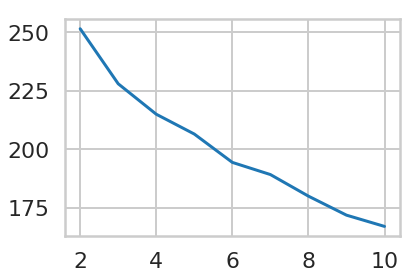

In [47]:
sns.lineplot(x=ss.keys(), y=ss.values())

**Make a bar chart showing the number of points in each cluster for k-means under the best  𝐾 .**

Best K is 10 as the ss is the lowest

In [48]:
predictions[10]

array([7, 6, 2, 0, 4, 3, 2, 8, 1, 0, 9, 2, 0, 6, 1, 2, 6, 2, 7, 1, 0, 8,
       3, 9, 2, 3, 6, 1, 6, 2, 4, 8, 1, 3, 8, 7, 1, 0, 9, 0, 2, 2, 8, 6,
       0, 3, 0, 4, 1, 1, 1, 3, 6, 2, 3, 8, 2, 4, 7, 6, 6, 8, 6, 7, 7, 2,
       2, 6, 9, 6, 6, 6, 3, 4, 6, 4, 2, 4, 8, 2, 3, 5, 6, 2, 7, 8, 0, 5,
       1, 8, 6, 8, 6, 4, 1, 3, 7, 6, 6, 3], dtype=int32)

Text(0,0.5,'number of points')

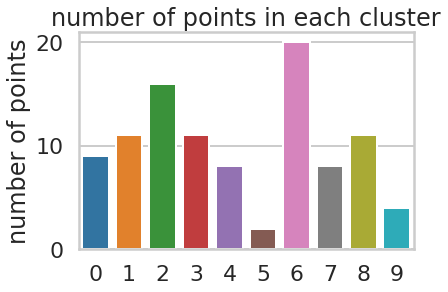

In [49]:
s = pd.Series(predictions[10])
grouped = s.value_counts()
# df = pd.DataFrame(predictions[10]).rename({0: "cluster"}, axis='columns')
# grouped = df.groupby("cluster").size()
ax = sns.barplot(x=grouped.index, y=grouped.values)
ax.set_title("number of points in each cluster")
ax.set_ylabel("number of points")

**What challenges did you experience using the Elbow method to pick  𝐾 ?**

**Answer:** Well. SS boils down the clustering to one number which is nice because it's easy to compare. However, what is happening within the cluster itself is a little bit of a black box.

Since SS is the sum of squared errors but without actually visualizing the cluster it's difficult to see what is going on - ie, are we overfitting? the quality of each cluster

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

**Answer:**

Plotting the silhouette plot and average silhouette score (red). We see that 5 clusters is actually the best instead of 10 clusters that we found by just looking at elbow score. 

It has 0 negative silhouette scores for most clusters except for the last oone and the highest average silhouette score ~ 0.135 which suggests reasonable structure for clustering.

Less than 5 clusters you have underfitting whereas more than 5 clusters you start to see overfitting. At 9 or above clusters, you start setting negative silhouette scores for almost all clusters meaning that there is more and more cluster overlap

Silhouette score give you much better information. It gives you insight into how well each point fits the cluster.

('For n_clusters =', 2, 'The average silhouette_score is :', 0.09174871508750351)
('For n_clusters =', 3, 'The average silhouette_score is :', 0.11889942863638556)
('For n_clusters =', 4, 'The average silhouette_score is :', 0.12167039851355937)
('For n_clusters =', 5, 'The average silhouette_score is :', 0.13528618244904822)
('For n_clusters =', 6, 'The average silhouette_score is :', 0.13218209978013543)
('For n_clusters =', 7, 'The average silhouette_score is :', 0.13365227784322317)
('For n_clusters =', 8, 'The average silhouette_score is :', 0.12482407120722075)
('For n_clusters =', 9, 'The average silhouette_score is :', 0.11686562917000483)
('For n_clusters =', 10, 'The average silhouette_score is :', 0.10889477148379977)


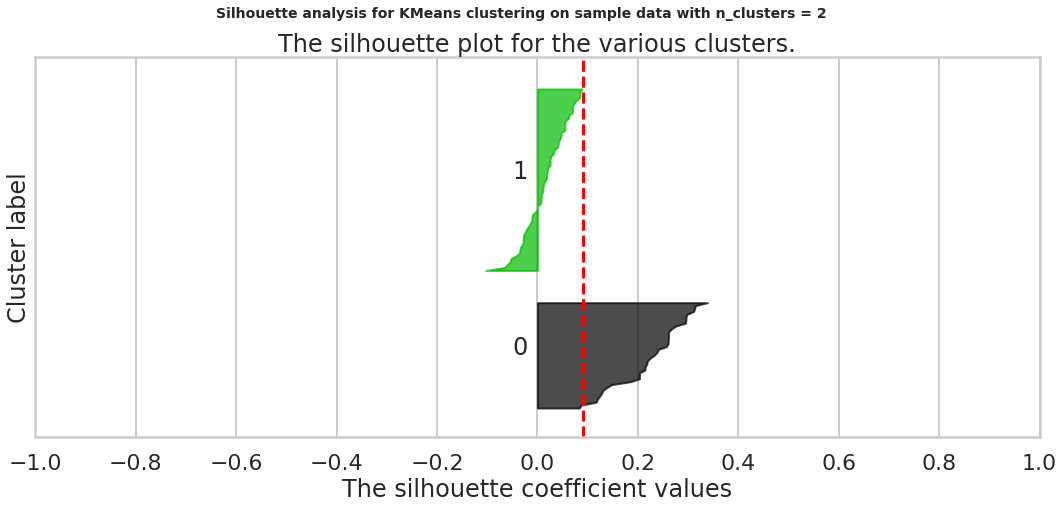

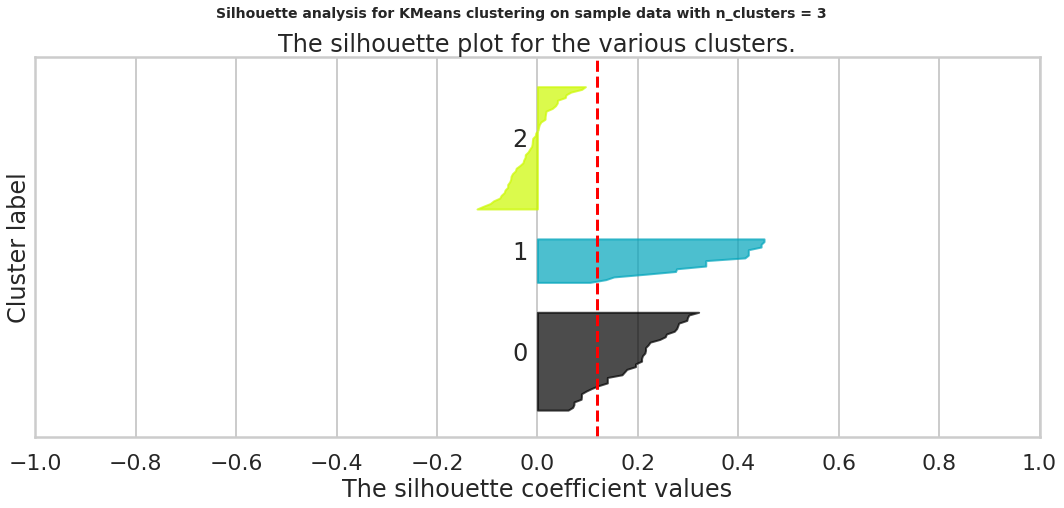

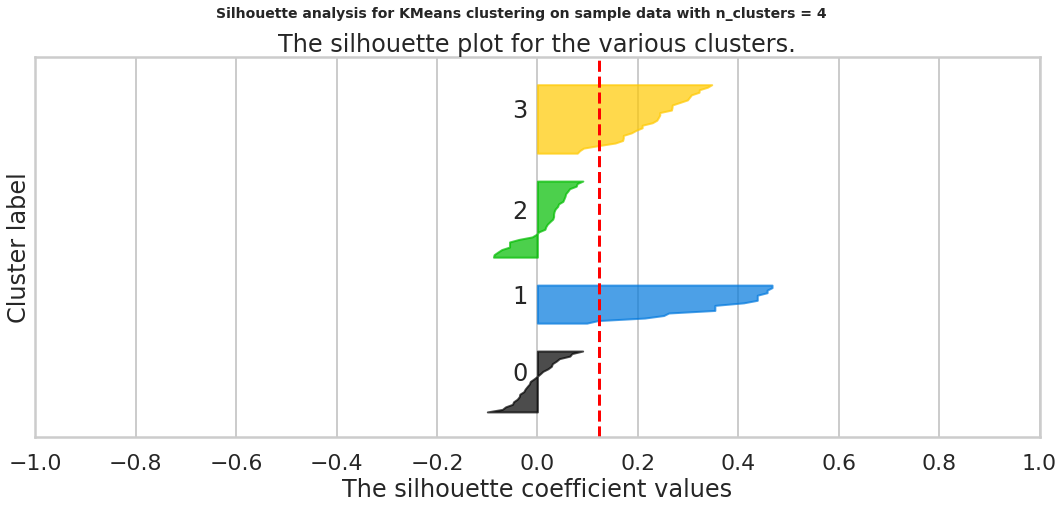

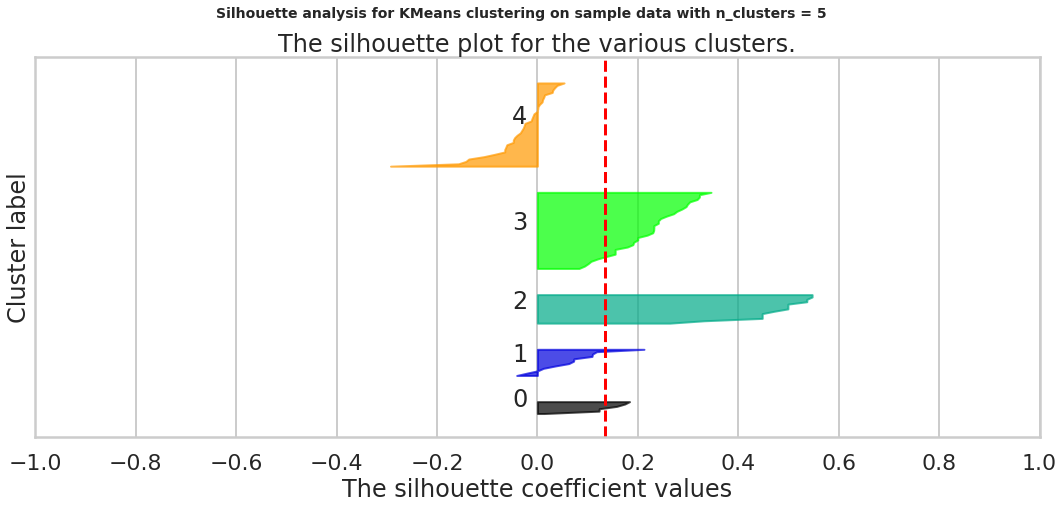

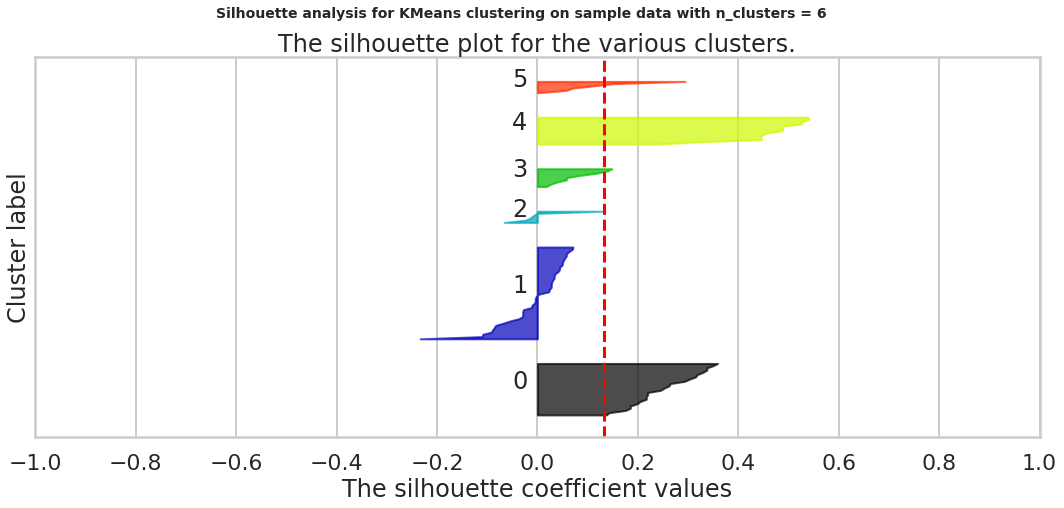

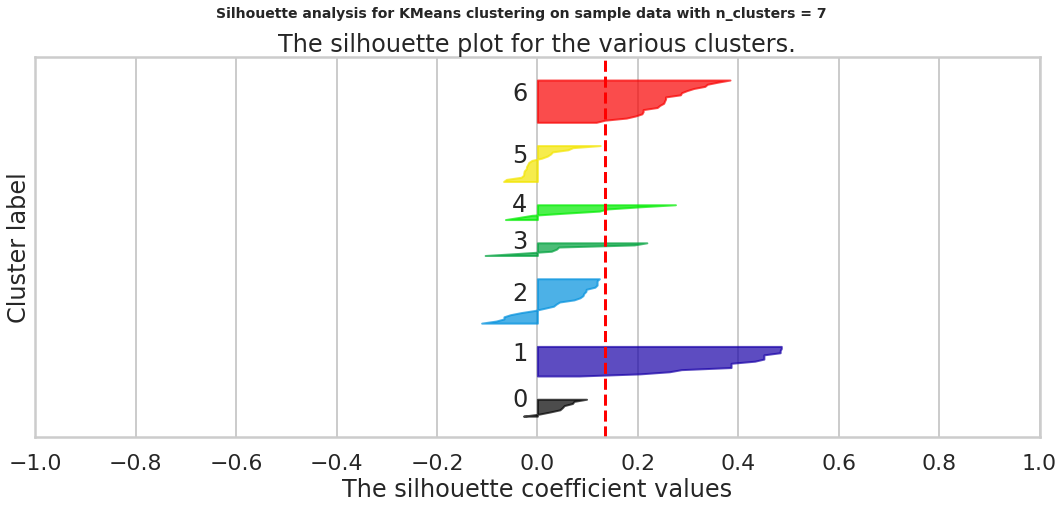

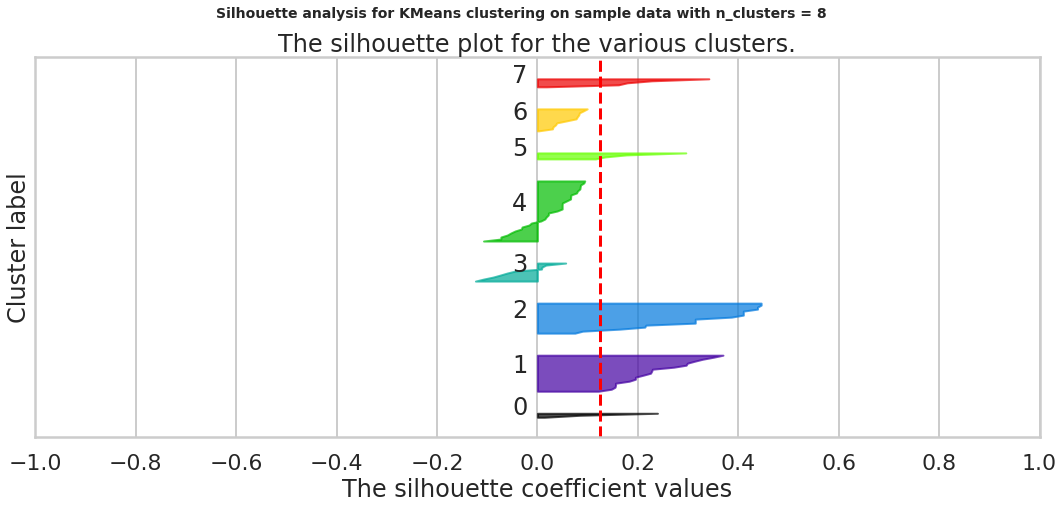

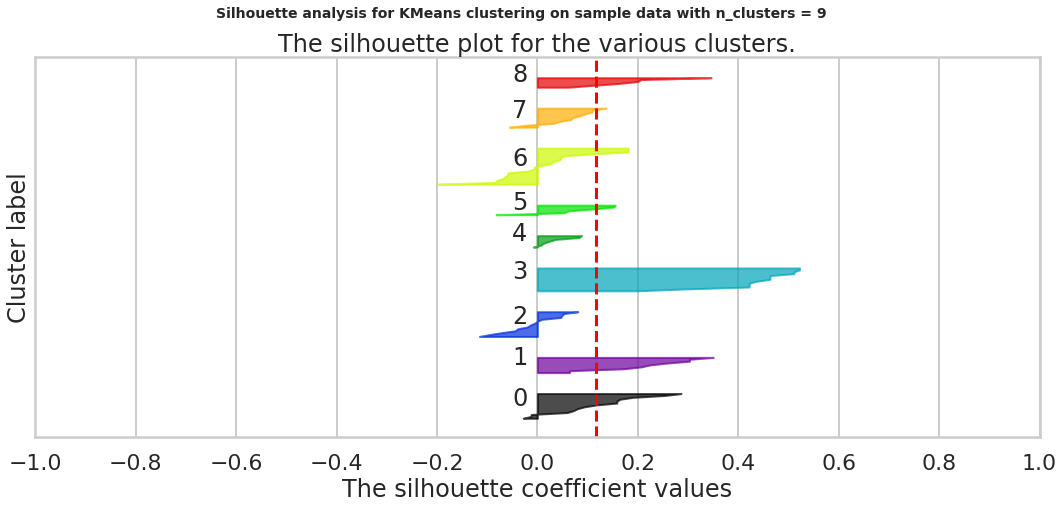

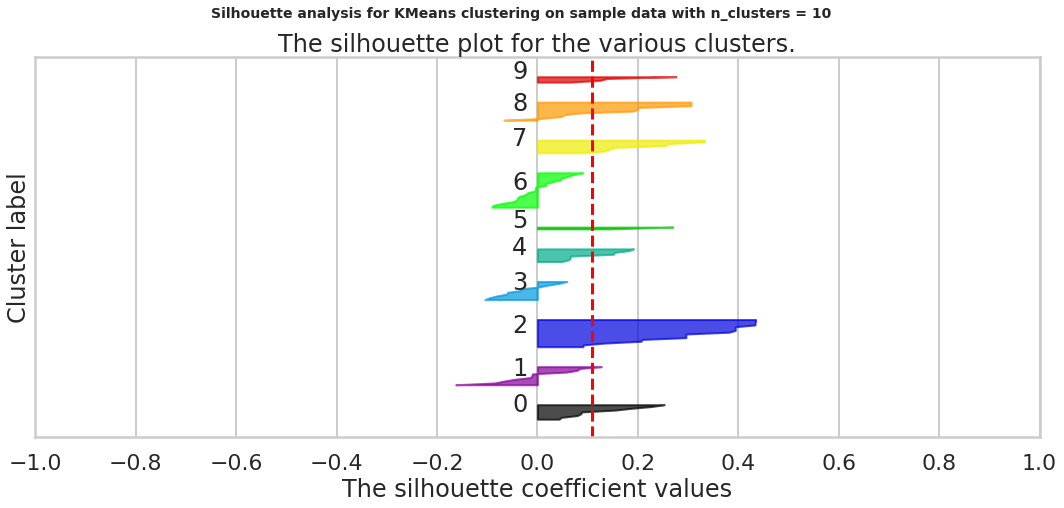

In [50]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np


for n_clusters in ss.keys():
      # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(18, 7)
    
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, predictions[n_clusters], random_state=1)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, predictions[n_clusters])

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[predictions[n_clusters] == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    
    

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [51]:
# convert feature matrix into columns
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(x_cols)

y = pd.Series(predictions[3])


cluster3_df = pd.concat([offer_df["customer_name"], 
                         pd.DataFrame(X)], 
                        axis='columns').rename({0: "x", 1: "y"}, axis='columns')
# have to split this into 2 commands since clusters column gets named to 0 as well
cluster3_df = pd.concat([cluster3_df, pd.Series(y)], 
                        axis='columns').rename({0: "cluster"}, axis='columns')
cluster3_df.head()


,customer_name,x,y,cluster
0,Adams,1.007580,0.108215,0
1,Allen,-0.287539,0.044715,2
2,Anderson,-0.392032,1.038391,1
3,Bailey,0.699477,-0.022542,0
4,Baker,0.088183,-0.471695,2


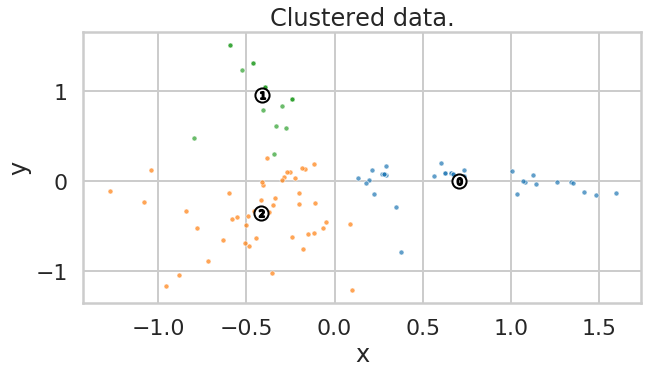

In [52]:
#your turn
from sklearn.decomposition import PCA

centers_2d = pca.transform(centers_km[3])

f, a = plt.subplots(1,1, figsize=(10, 5))


# 2nd Plot showing the actual clusters formed
# colors = cm.nipy_spectral(predictions[3].astype(float) / 3)
for i in cluster3_df['cluster'].unique():
  sns.scatterplot(data=cluster3_df[cluster3_df.cluster == i],
                 x="x", y="y", marker=".", s=100, alpha=0.7, ax=a)

# Labeling the clusters
# centers = centers_km[3]
# Draw white circles at cluster centers
a.scatter(centers_2d[:, 0], centers_2d[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers_2d):
    a.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

a.set_title("Clustered data.")

plt.show()

In [53]:
df_offers.groupby("varietal").size()

varietal
Cabernet Sauvignon    6
Champagne             7
Chardonnay            2
Espumante             3
Malbec                2
Merlot                3
Pinot Grigio          1
Pinot Noir            4
Prosecco              4
dtype: int64

**Based on what you see, what seems to be the best value for  𝐾 ? Moreover, which method of choosing  𝐾  seems to have produced the optimal result visually?**


Difficult to tell but from visually looking at the plot. The blue cluster can potentially be separated into 3 clusters. Green and Orange looks like they make make sense but there are some outliers on the left for both clusters.




**Exercise: Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?**

There were 9 different types of wine and 32 offers. Distribution of offers are not even so potentially the larger cluster - ie, orange is for something like Champagne and Cabernet

Also there were less clusters than wine types that were offered so this suggests that customers that multiple types of wines must be clustered into one meaning that customers that like one type of wine will probably buy from offers for a similiar type of wine


**TODO: Is there a way to see which offer correlates to which cluster -ie some type of covariance matrix of some sort that we can use to gain more insights into the cluster - or some type of feature importance method?**



**Further Analysis on features and clustering**

In [142]:
# first merge in clustering with customer and campaign information
merged_customer_offer_with_cluster = df_transactions.merge(df_offers, how="outer", on="offer_id")
merged_customer_offer_with_cluster = merged_customer_offer_with_cluster.merge(cluster3_df, how="left", on="customer_name").drop(["x", "y"], axis='columns')
merged_customer_offer_with_cluster.head()




,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak,cluster
0,Smith,2,1,January,Pinot Noir,72,17,France,False,1
1,Rodriguez,2,1,January,Pinot Noir,72,17,France,False,1
2,Martin,2,1,January,Pinot Noir,72,17,France,False,2
3,Jackson,2,1,January,Pinot Noir,72,17,France,False,2
4,Campbell,2,1,January,Pinot Noir,72,17,France,False,1


In [82]:
# get total transactinos per cluster
total_transactions_per_cluster = pd.crosstab(merged_customer_offer["cluster"], columns=['campaign']).values.reshape((3,)).tolist()
total_transactions_per_cluster


[102, 45, 177]

In [0]:
def plot_cluster_analysis(column, display_name):
  analysis_ds = pd.DataFrame()
  analysis_ds['Total'] = merged_customer_offer_with_cluster.groupby('cluster')[column].value_counts()
  analysis_ds = analysis_ds.reset_index()

  fig, a = plt.subplots(figsize=(10,5))
  sns.barplot(x='cluster', y='Total', data=analysis_ds, hue=column, ax=a, palette='Spectral')
  a.set_xlabel('Clusters')
  a.set_title('Clusters by %s' % display_name)

  # add info bar on the bottom to show how many transactions per cluster
  space = 0.0
  for item in range(len(total_transactions_per_cluster)):
    a.text(x=-.5+space, y=-20, s='Total Transactions %d' % total_transactions_per_cluster[item],
          withdash=True, fontsize=14)
    space += 1.05

  # leg = ax.legend(loc=)
  a.legend(bbox_to_anchor=(1.05, 1), loc='2', borderaxespad=0.)
  plt.savefig('%sTotalTransPerCluster' % display_name)

**Let's Look at clustering by campaign months**

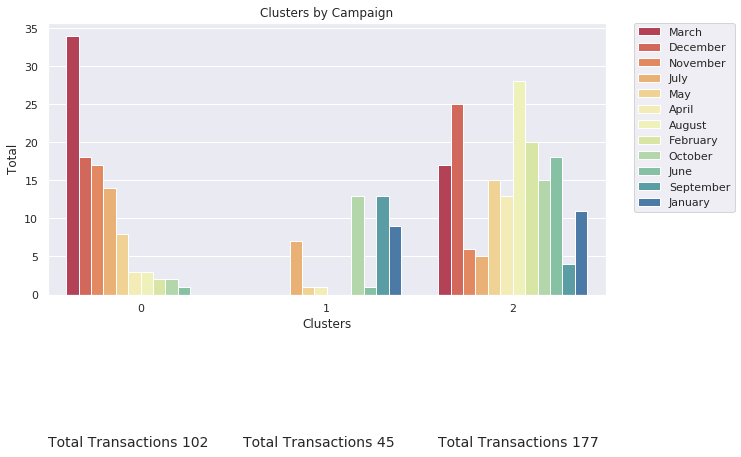

In [144]:
# month_ds = pd.DataFrame()
# month_ds['Total'] = merged_customer_offer_with_cluster.groupby('cluster')['campaign'].value_counts()
# month_ds = month_ds.reset_index()

# fig, a = plt.subplots(figsize=(10,5))
# sns.barplot(x='cluster', y='Total', data=month_ds, hue='campaign', ax=a, palette='Spectral')
# a.set_xlabel('Clusters')
# a.set_title('Seasonal Total Campaigns By Clusters')

# # add info bar on the bottom to show how many transactions per cluster
# space = 0.0
# for item in range(len(total_transactions_per_cluster)):
#   a.text(x=-.5+space, y=-10, s='Total Transactions %d' % total_transactions_per_cluster[item],
#         withdash=True, fontsize=14)
#   space += 1.05
  
# # leg = ax.legend(loc=)
# a.legend(bbox_to_anchor=(1.05, 1), loc='2', borderaxespad=0.)
# plt.savefig('SeasonalTotalTransPerCluster')
plot_cluster_analysis('campaign', "Campaign")

**Let's look at clustering by varietal**

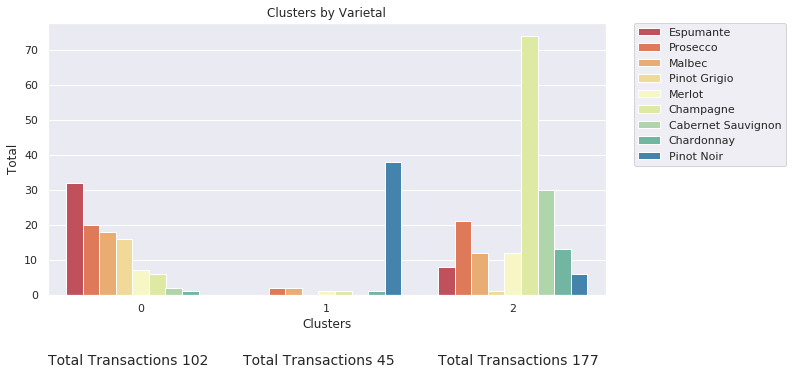

In [111]:
plot_cluster_analysis('varietal', "Varietal")

**Clusters by Minimum Quantity**

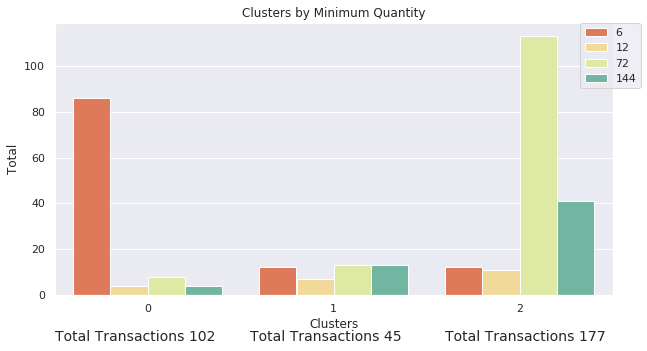

In [112]:
# min_qty_ds = pd.DataFrame()
# min_qty_ds['Total'] = merged_customer_offer_with_cluster.groupby('cluster')['min_qty'].value_counts()
# min_qty_ds = min_qty_ds.reset_index()

# fig, a = plt.subplots(figsize=(10,5))
# sns.barplot(x='cluster', y='Total', data=min_qty_ds, hue='min_qty', ax=a, palette='Spectral')
# a.set_xlabel('Clusters')
# a.set_title('Minimum Quantity Campaigns By Clusters')

# # add info bar on the bottom to show how many transactions per cluster
# space = 0.0
# for item in range(len(total_transactions_per_cluster)):
#   a.text(x=-.5+space, y=-20, s='Total Transactions %d' % total_transactions_per_cluster[item],
#         withdash=True, fontsize=14)
#   space += 1.05
  
# # leg = ax.legend(loc=)
# a.legend(bbox_to_anchor=(1.05, 1), loc='2', borderaxespad=0.)
# plt.savefig('MinQtyTransPerCluster')
plot_cluster_analysis('min_qty', "Minimum Quantity")

**Clusters By Discounts**

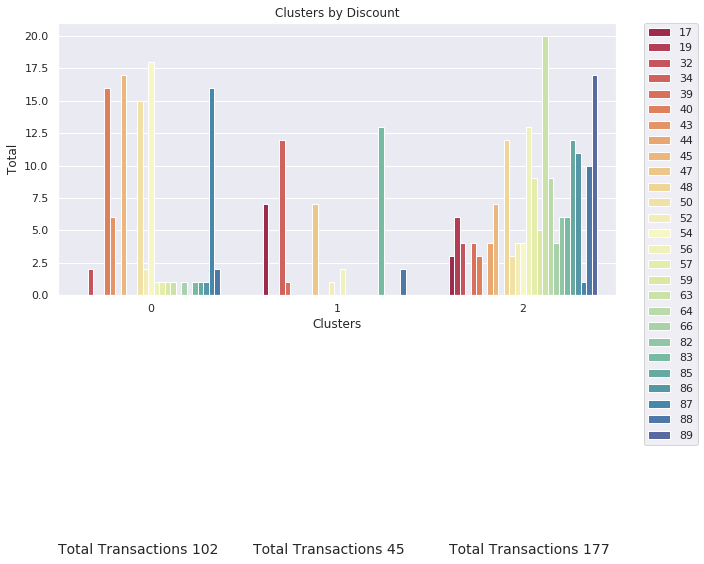

In [113]:
plot_cluster_analysis('discount', 'Discount')

**Cluster by Origin**


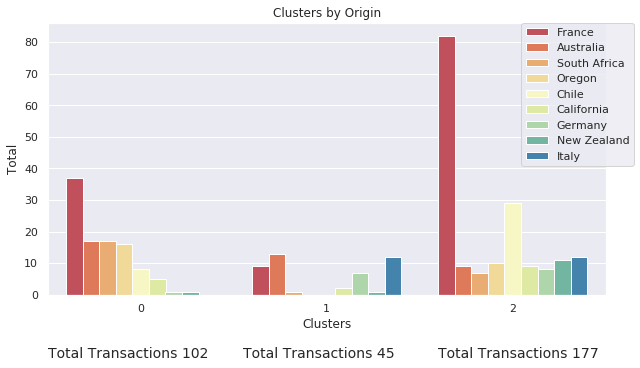

In [114]:
plot_cluster_analysis('origin', 'Origin')

**Clusters by Past Peak**

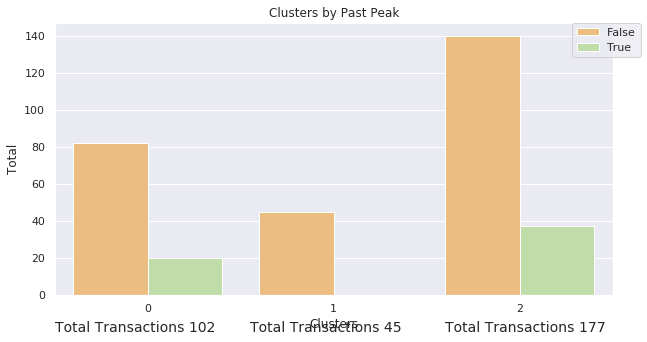

In [115]:
plot_cluster_analysis('past_peak', 'Past Peak')

**Deeper Analysis of Clustering**

**Cluster 0**
* **Campaign Month** - Very likely to purchase in March. Outside of that good months to send offers to this group is December, November, July, and May
* **Varietal** - this group tends to like the following wines: Espumante, Prosecco, Malbec, Pino Griogio more than the rest of the groups. Interestingly, this is the only group that actually likes Pinot Grigio.
* **Minimum Quantity** - this group heavily favors purchasing when there is a low minimum quantity
* **Discount** - this group mostly purchased wine between 39% to 54% discount - which are the lower tiers of discounts - I would say that -  as long as the discount is 30% or more this group probably does not care about discounts as much as cluster 2
* **Origin** - this group heavily favors wine from France. Next are Australia, South Africa, Oregon, an then California. Low probably that this group will purcahse wine from California, Germany and new Zealand. 0 purchases from this group on Italian wine
* **Past Peak** - this group purchased a mix of past peak and non-past peak wine although their affinity to purchase past peak is less than Cluster 2

Summary - mid level consumer:
* Tends to purchase wines that are not heavily discounted
* Only group that likes Pino Grigios
* Likes low minimum purchase


**Cluster 1**
* **Campaign Month** - Heavy seasonality affinity for this group as most purchases are made in September, October, November, and January - towards the fall and winter seasons
* **Varietal** - this group mostly only purchased Pino Noirs
* **Minimum Quantity** - pretty evenly distributed for purchases and minimum quantity. I would say this group does not care about minimum quantity
* **discount** - there are small numbers of purchases in this group and purchases range from high to low discounts - even  more so than cluster 1, this group probably does not care as much about discounts than the other 2
* **Origin** - This group mostly only purchase wine from France, Australia, Germany, and Italy. No purchases from Oregon and Chile and very low frmo other countries
* **Past Peak** - customers in this group did not purchase any wines that are past peak

Summary - the fancy group:
* Ends to purchase between Septebmer and January oonly
* Discount rate has little affect into buying decisions
* Almost exclusively only purchase French wines
* Will not purchase past peak wines


**Cluster 2**
* **Campaign Month** - This group tends to purchase year round with low likelihood to purchase in November, July, and September
* **Varietal** - this group really likes champagnes. 2nd most successful are Malbecs and Cabernets. This group rarely purchases Pinot Grigios
* **Minimum Quantity** - opposite to cluster 0, this group actually heavily favors purchasing with minimum quantity of 72 and above suggesting these are bulk buyer - perhaps they are associated with restaurants or some type of event company
* **discount** - this group purchased wines from almost all ranges of discounts. The graph does tend to suggest that the group tends to purcahse wines that are heavily discounted
* **Origin** - this group has highest finity to purchase wine from France and Chile. Around 45% of the wine purchased in this group is from France and 17% from Chile. Outside of France and Chile, this group seems to be pretty indifferent to the origin
* **Past Peak** - this cluster group has the highest affinity to purchase wine that are past peak. Around 30% of the wine purchased in this group was past peak. Only around 20% in cluster 1 purchased past peak wine

Summary - lower end restaurant owner:
* likes to buy in bulk
* likes wine from France and Chile but not opposed to other
* year round purchaser
* lean towards heavily discounted wines and most likely to purchase past peak



What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

In [16]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [17]:
pca.explained_variance_

array([0.4096489 , 0.30753551, 0.2022926 , 0.16703717, 0.15015248,
       0.1434373 , 0.13818887, 0.12192294, 0.11636172, 0.10804271,
       0.09937813, 0.09495961, 0.08690352, 0.07256738, 0.0660996 ,
       0.06245473, 0.05634388, 0.05327395, 0.04728801, 0.04393911,
       0.03900424, 0.03625783, 0.03455714, 0.03235091, 0.02940632,
       0.02618221, 0.02308167, 0.02142632, 0.018814  , 0.0165252 ,
       0.01426187, 0.0077789 ])

**This value is one possible value for the optimal number of dimensions. What is it?**

After around 3 dimension, the slop steadily decreases at around the same rate. The Elbow plot for explained variance is not quite as pronounced as I would hope.

Most of the variance is explained somewhere around 3 dimensions so I would not drop down to below that. This seems to be the optimal number of dimensions.

There is another slight change in slope around 12 dimensions and after. If you need more than 3 dimensions in the model, the next natural pick would be around 12.







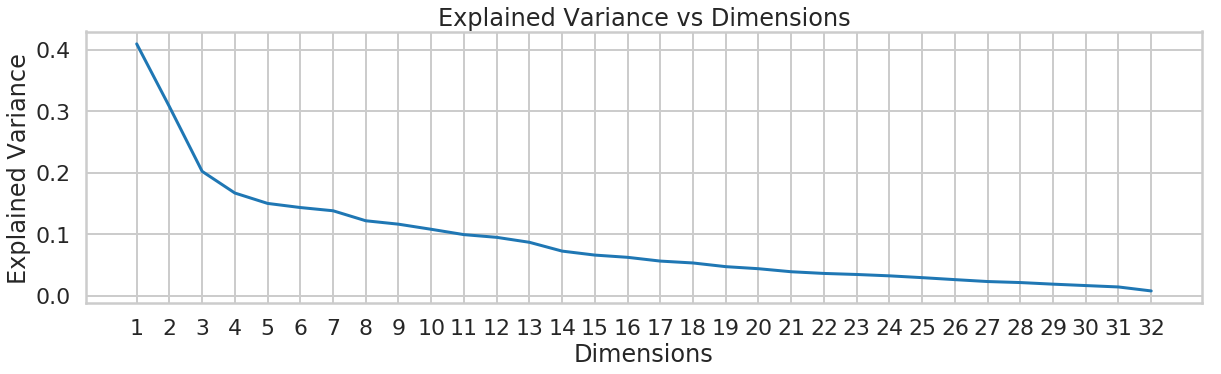

In [18]:
f, a = plt.subplots(1, 1, figsize=(20,5))
sns.lineplot(x=np.arange(1,33), y=pca.explained_variance_, ax=a)
a.set_xlabel("Dimensions")
a.set_ylabel("Explained Variance")
a.set_xticks(np.arange(1,33))
_ = a.set_title("Explained Variance vs Dimensions")

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [0]:
# reuse this to plot clusters and centers

# reduct dimensions to 2 for late
pca_2d = PCA(n_components=2)
x_2d = pd.DataFrame(pca_2d.fit_transform(x_cols)).rename({0: "x", 1: "y"}, axis='columns')


def plot_cluster(model, X):
  print("Number of clusters found: %d" % len(np.unique(model.labels_)))
  print("Silhouette score: %f" % silhouette_score(X, model.labels_))
  

  # concat X with clusters and plot
  out_df = pd.concat([x_2d, pd.Series(model.labels_)], axis='columns').rename({0: "cluster"}, axis='columns')
  f, a = plt.subplots(1,1, figsize=(10, 5))


  # 2nd Plot showing the actual clusters formed
  # colors = cm.nipy_spectral(predictions[3].astype(float) / 3)
  for i in np.unique(model.labels_):
    sns.scatterplot(data=out_df[out_df.cluster == i],
                   x="x", y="y", marker=".", s=100, alpha=0.7, ax=a)

  # Labeling the clusters
  # centers = centers_km[3]
  # Draw white circles at cluster centers
  if hasattr(model, 'cluster_centers_'):
    centers_2d = pca.transform(model.cluster_centers_)

    a.scatter(centers_2d[:, 0], centers_2d[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers_2d):
        a.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

  a.set_title("Clustered data.")

  plt.show()

In [0]:
# reduce dimensions to 3D
pca_3d = PCA(n_components=3)
x_3d = pd.DataFrame(pca_3d.fit_transform(x_cols)).rename({0: "x", 1: "y", 2: "z"}, axis='columns')


Number of clusters found: 14
Silhouette score: 0.123465


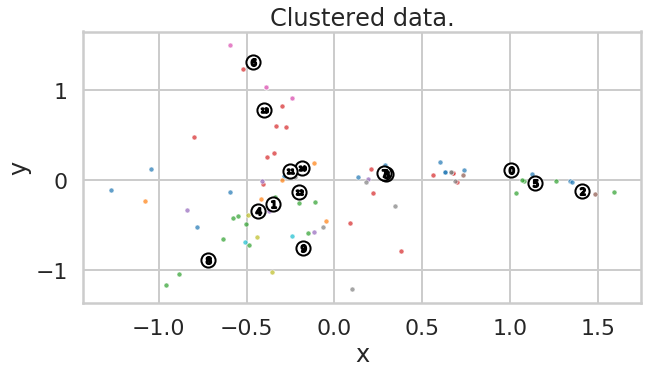

In [21]:
from sklearn.cluster import AffinityPropagation


# Affinity Propagation
ap = AffinityPropagation()
ap.fit_predict(x_cols)
plot_cluster(ap, x_cols)




In [0]:
from mpl_toolkits.mplot3d import Axes3D

def plot_cluster_3d(model, X):
  print("Number of clusters found: %d" % len(np.unique(model.labels_)))
  print("Silhouette score: %f" % silhouette_score(X, model.labels_))
  

  # concat X with clusters and plot
  out_df = pd.concat([x_3d, pd.Series(model.labels_)], axis='columns').rename({0: "cluster"}, axis='columns')
#   print(out_df.head())
  fig = plt.figure(figsize=(10, 10))
  a = fig.add_subplot(111, projection='3d')


#   print(out_df[out_df.cluster == 1].head())
  
  # 2nd Plot showing the actual clusters formed
  # colors = cm.nipy_spectral(predictions[3].astype(float) / 3)
  for i in np.unique(model.labels_):
    a.scatter(out_df[out_df.cluster == i]["x"], 
              out_df[out_df.cluster == i]["y"], 
              out_df[out_df.cluster == i]["z"], 
              marker=".", s=100, alpha=0.7)

  # Labeling the clusters
  # centers = centers_km[3]
  # Draw white circles at cluster centers
  if hasattr(model, 'cluster_centers_'):
    centers_3d = pca_3d.transform(model.cluster_centers_)

    a.scatter(centers_3d[:, 0], centers_3d[:, 1], centers_3d[:, 2], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers_3d):
      a.scatter(c[0], c[1], c[2], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

  a.set_title("3D Clustered Data")

  plt.show()

Number of clusters found: 14
Silhouette score: 0.123465


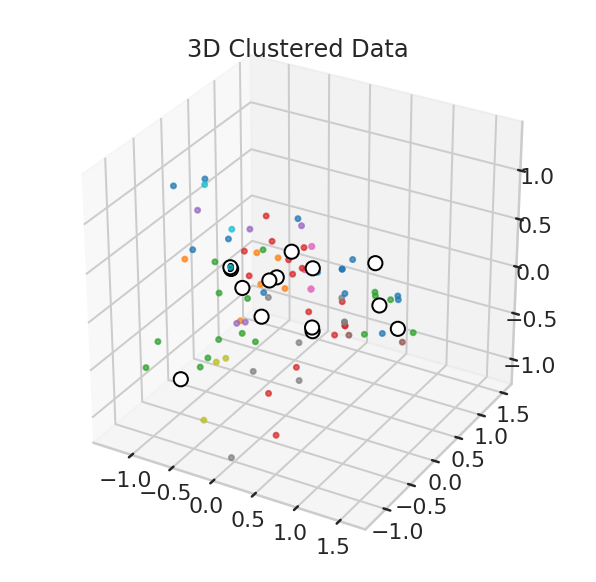

In [23]:
plot_cluster_3d(ap, x_cols)

Number of clusters found: 3
Silhouette score: 0.106115


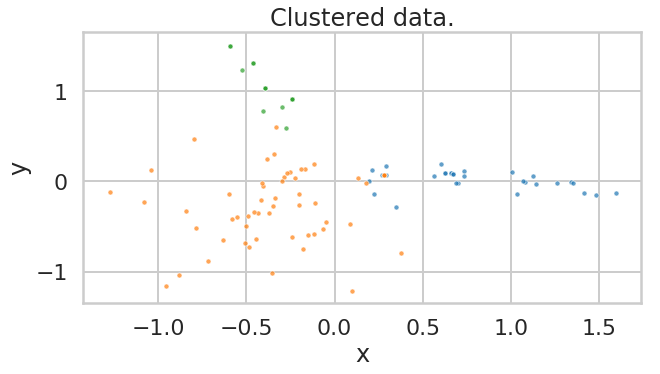

Number of clusters found: 3
Silhouette score: 0.106115


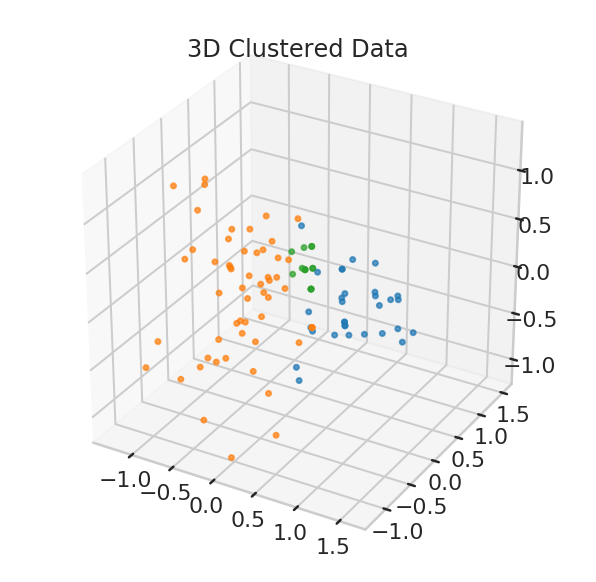

Number of clusters found: 4
Silhouette score: 0.086279


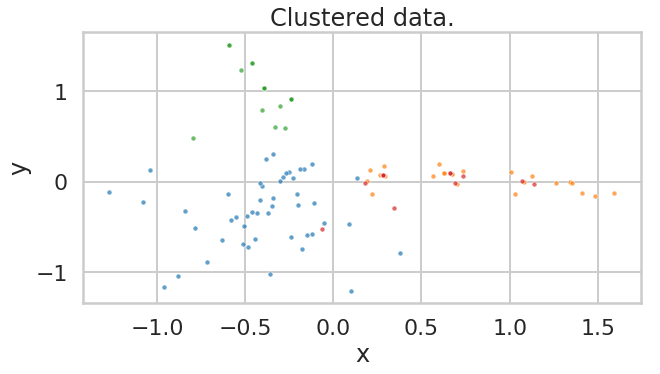

Number of clusters found: 4
Silhouette score: 0.086279


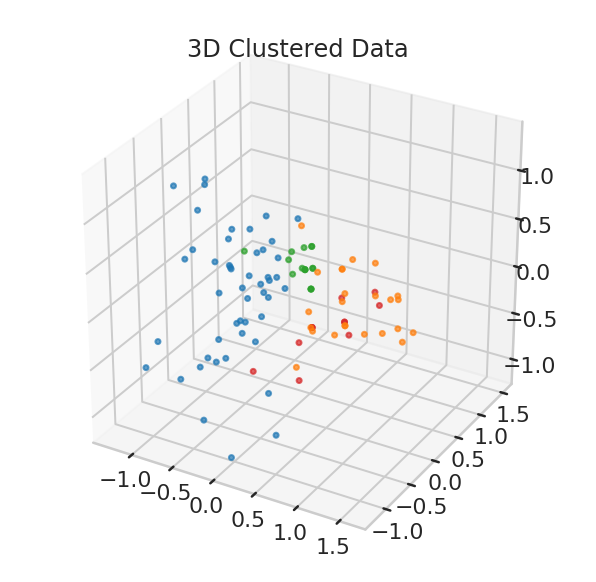

Number of clusters found: 5
Silhouette score: 0.099934


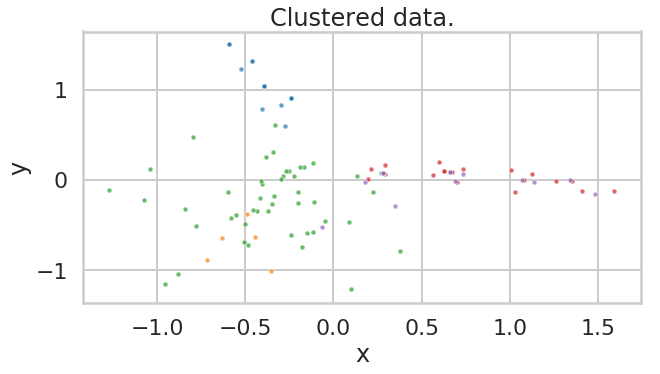

Number of clusters found: 5
Silhouette score: 0.099934


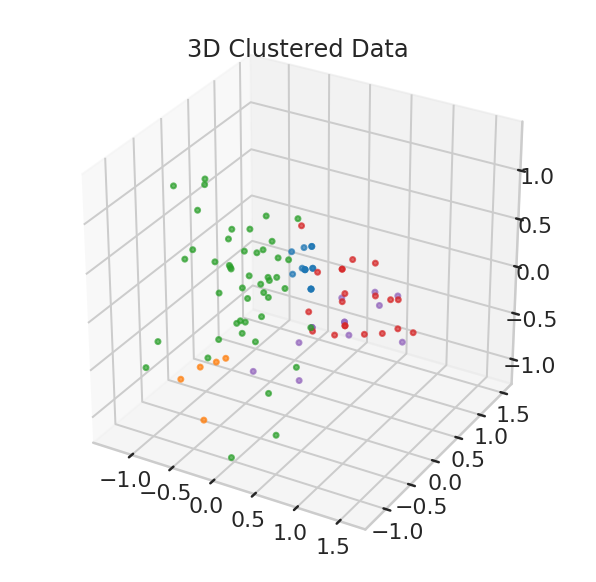

Number of clusters found: 6
Silhouette score: 0.107187


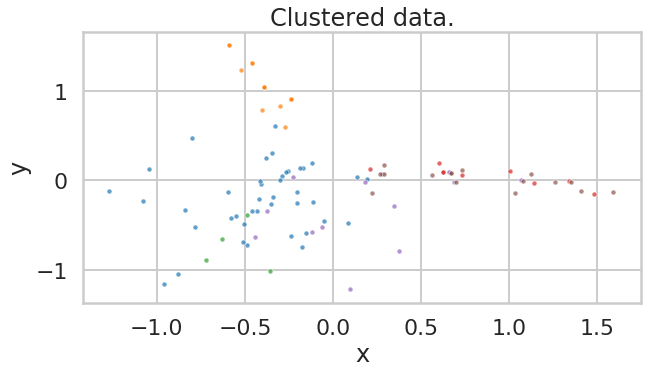

Number of clusters found: 6
Silhouette score: 0.107187


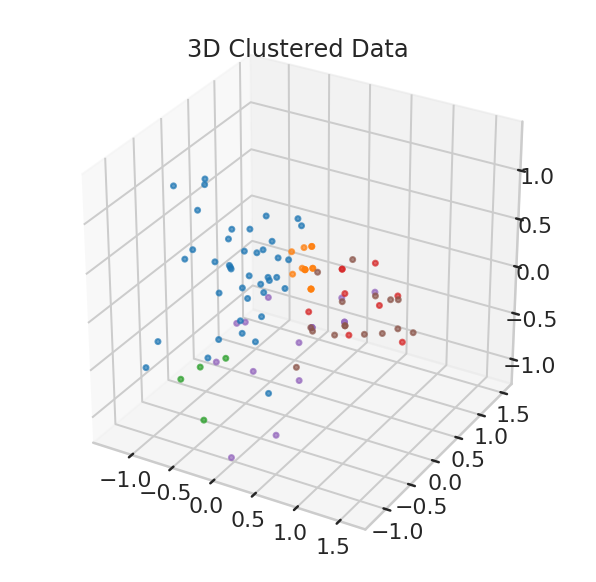

In [24]:
from sklearn.cluster import SpectralClustering

# Spectral Clustering
for i in np.arange(3, 7):
  sc = SpectralClustering(i, random_state=1)
  sc.fit_predict(x_cols)
  plot_cluster(sc, x_cols)
  plot_cluster_3d(sc, x_cols)



Number of clusters found: 3
Silhouette score: 0.116259


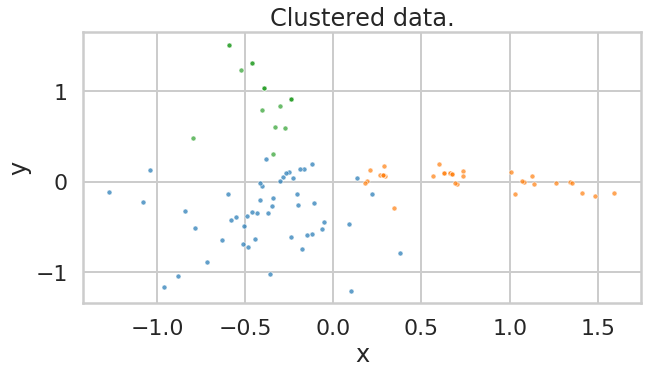

Number of clusters found: 3
Silhouette score: 0.116259


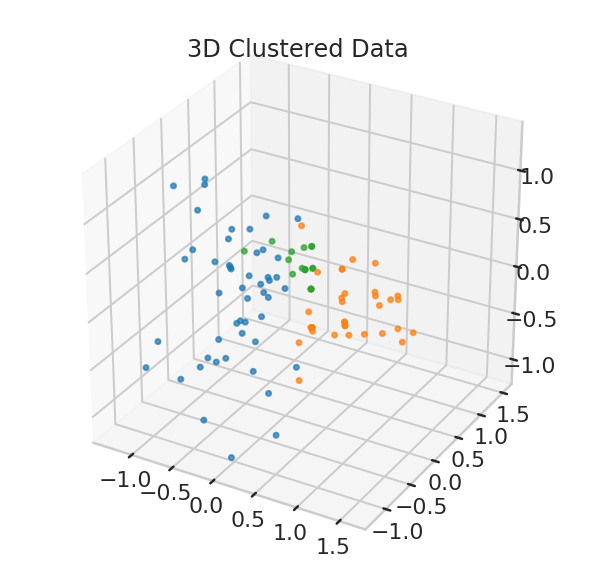

Number of clusters found: 4
Silhouette score: 0.128938


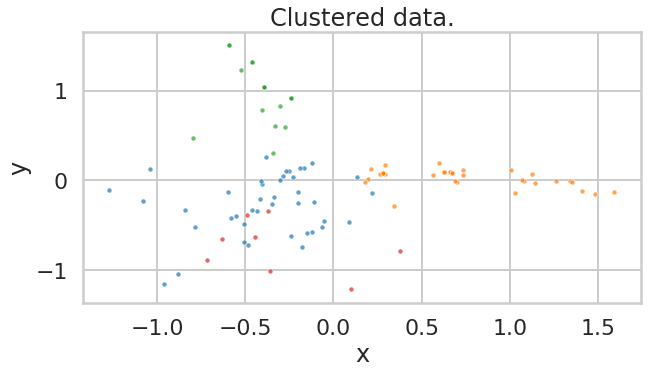

Number of clusters found: 4
Silhouette score: 0.128938


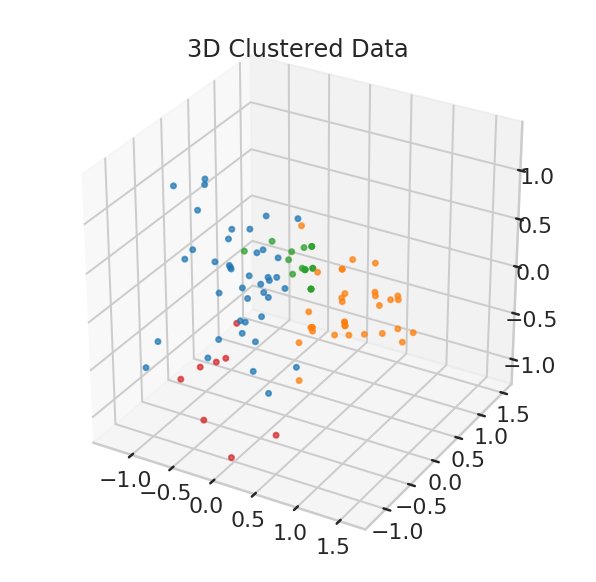

Number of clusters found: 5
Silhouette score: 0.140897


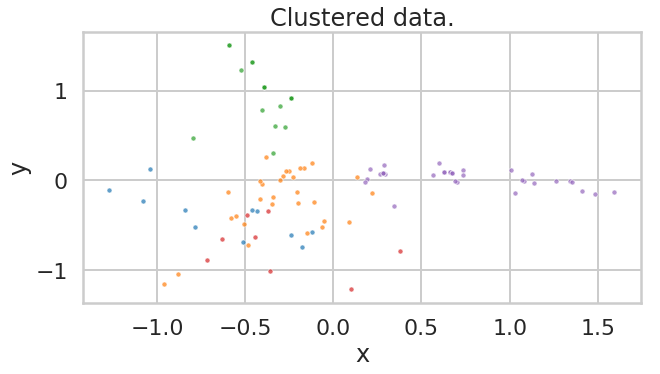

Number of clusters found: 5
Silhouette score: 0.140897


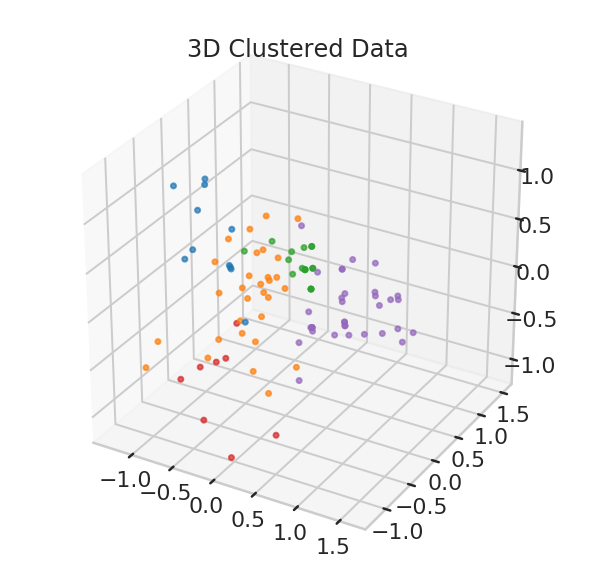

Number of clusters found: 6
Silhouette score: 0.147152


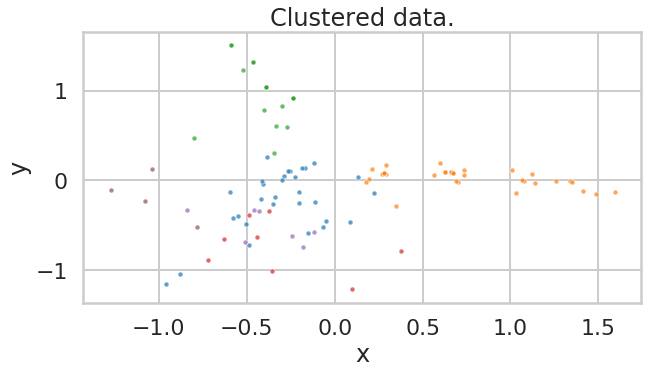

Number of clusters found: 6
Silhouette score: 0.147152


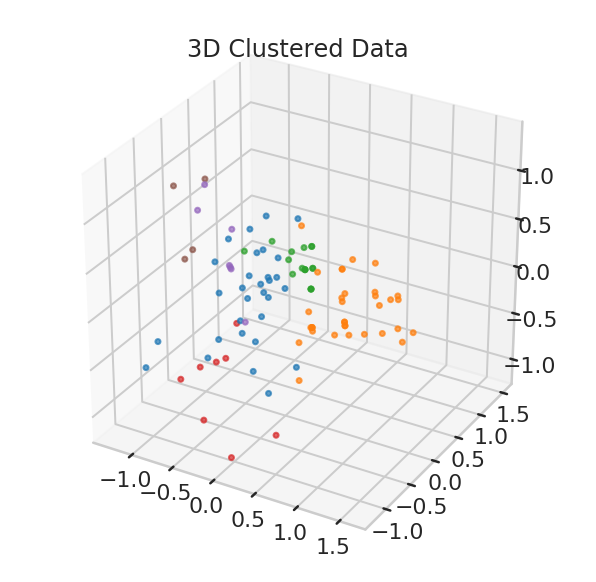

In [25]:
from sklearn.cluster import AgglomerativeClustering

for i in np.arange(3, 7):
  ac = AgglomerativeClustering(n_clusters=i)
  ac.fit_predict(x_cols)
  plot_cluster(ac, x_cols)
  plot_cluster_3d(ac, x_cols)

Number of clusters found: 5
Silhouette score: 0.012715


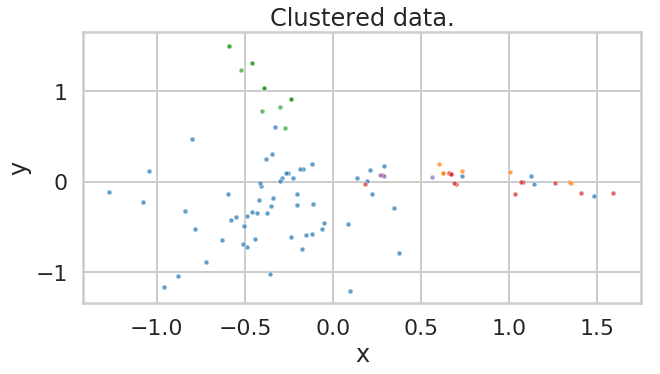

Number of clusters found: 5
Silhouette score: 0.012715


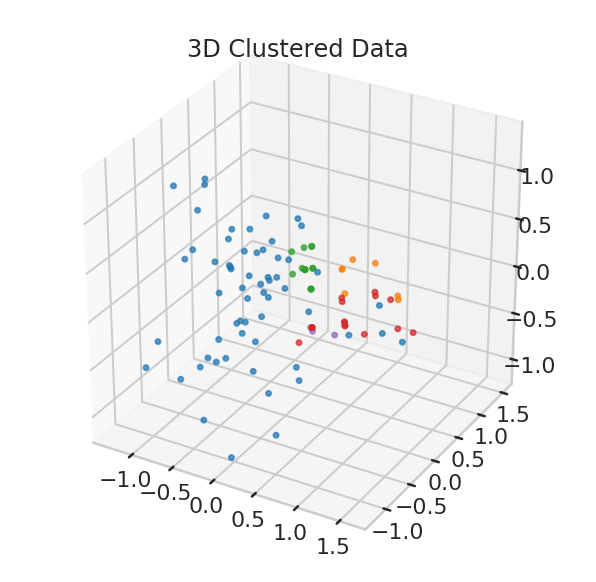

Number of clusters found: 5
Silhouette score: 0.012715


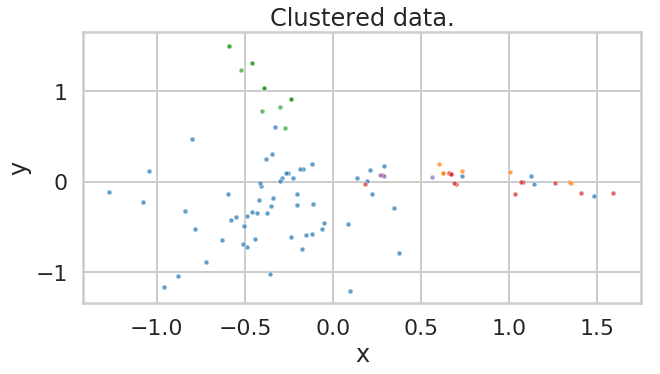

Number of clusters found: 5
Silhouette score: 0.012715


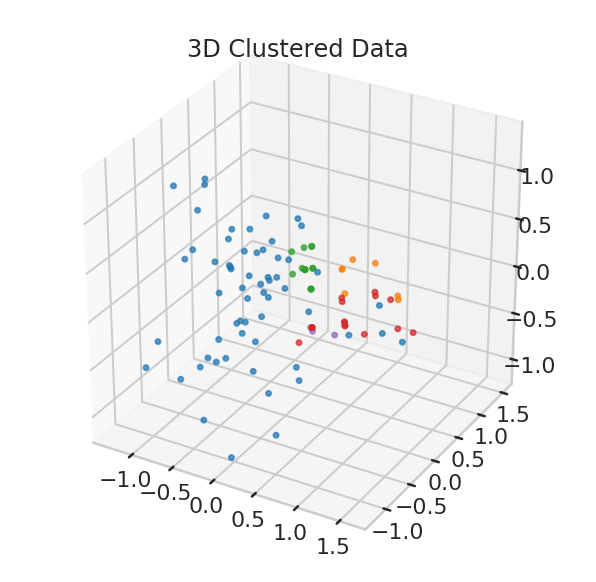

Number of clusters found: 5
Silhouette score: 0.012715


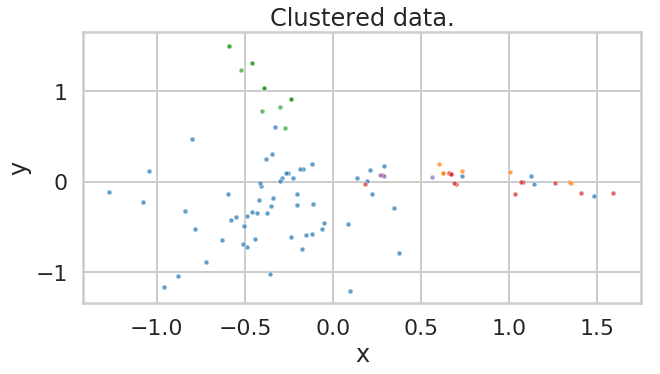

Number of clusters found: 5
Silhouette score: 0.012715


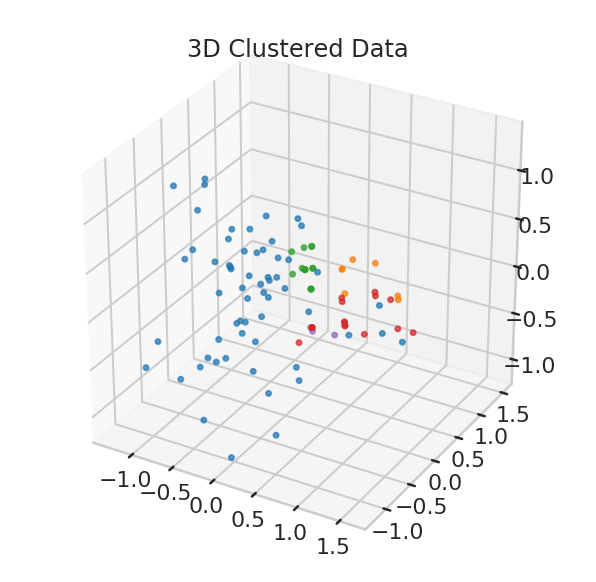

Number of clusters found: 5
Silhouette score: 0.012715


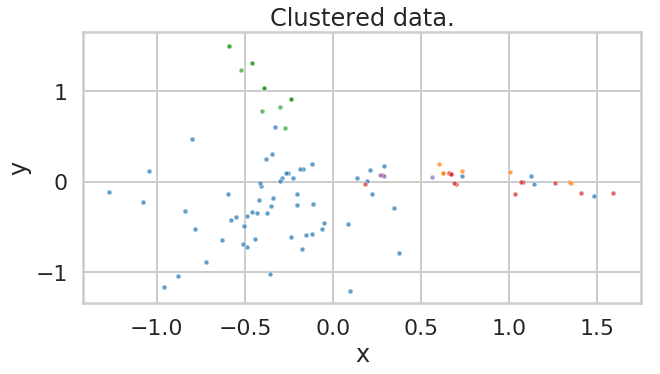

Number of clusters found: 5
Silhouette score: 0.012715


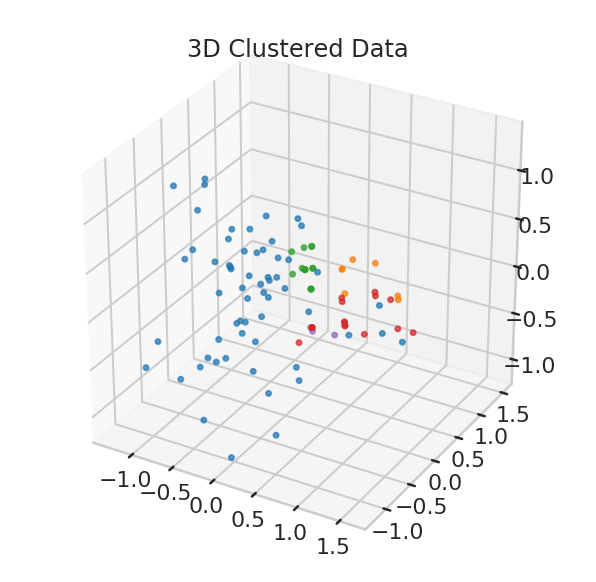

Number of clusters found: 5
Silhouette score: 0.012715


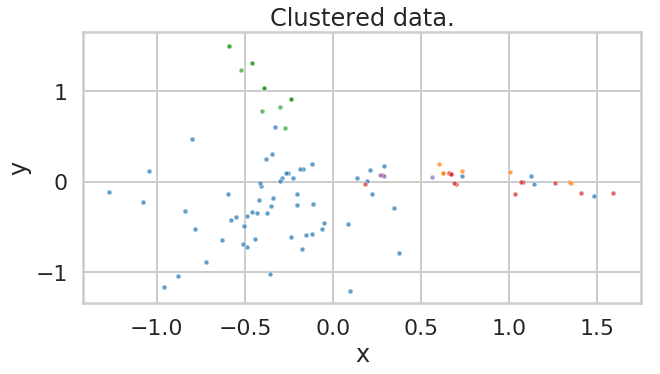

Number of clusters found: 5
Silhouette score: 0.012715


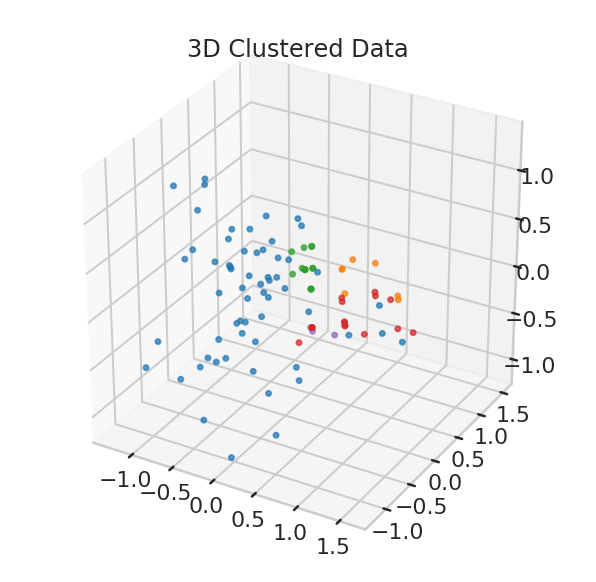

Number of clusters found: 2
Silhouette score: 0.119899


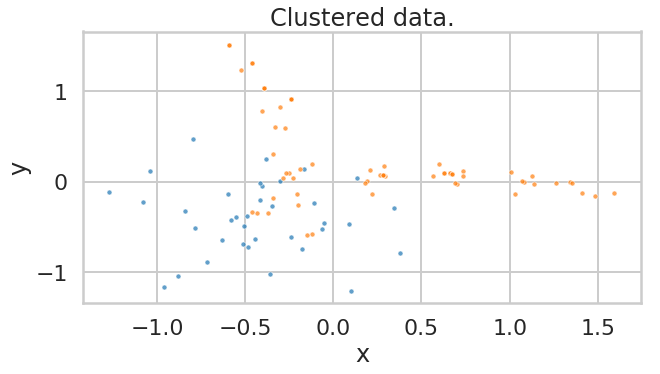

Number of clusters found: 2
Silhouette score: 0.119899


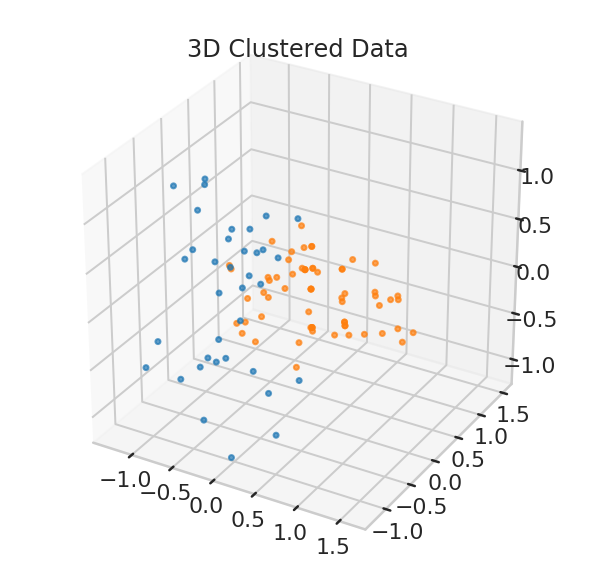

Number of clusters found: 2
Silhouette score: 0.119899


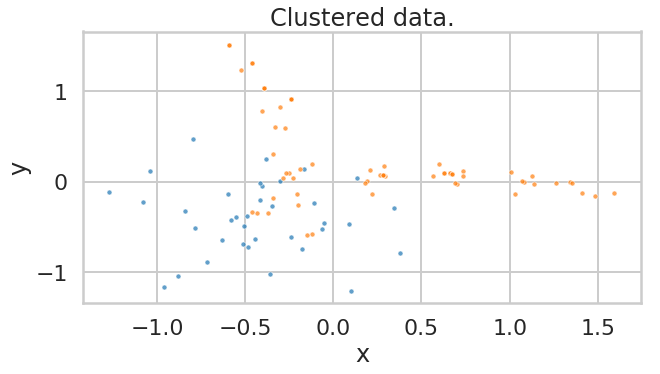

Number of clusters found: 2
Silhouette score: 0.119899


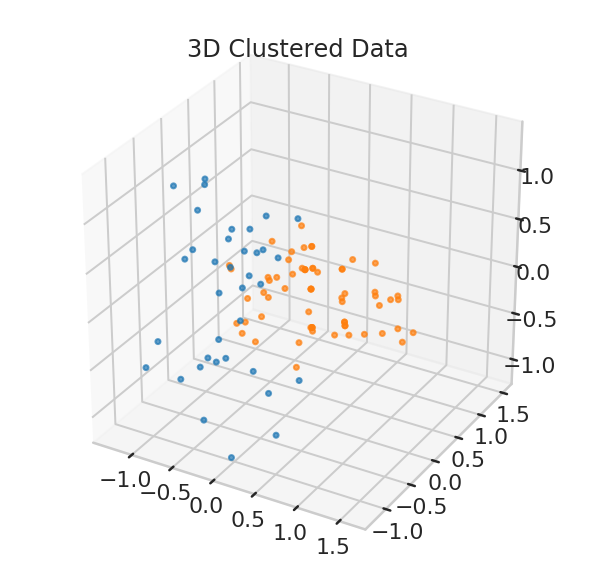

Number of clusters found: 2
Silhouette score: 0.119899


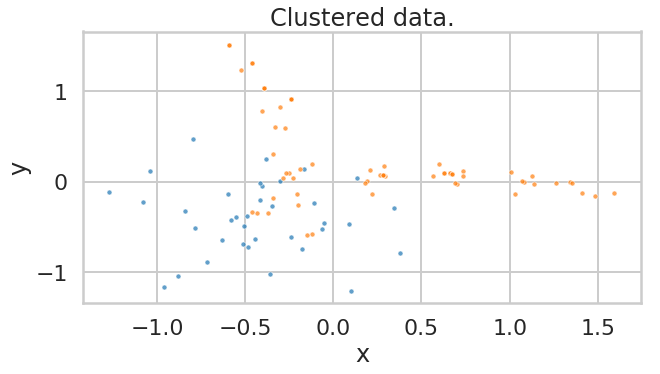

Number of clusters found: 2
Silhouette score: 0.119899


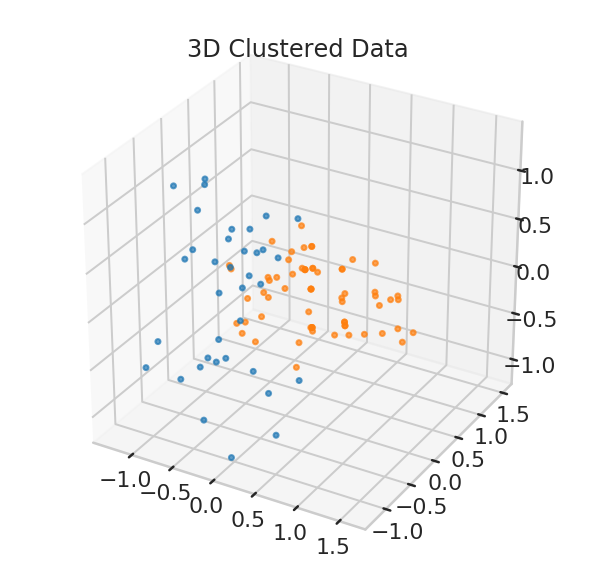

Number of clusters found: 2
Silhouette score: 0.180204


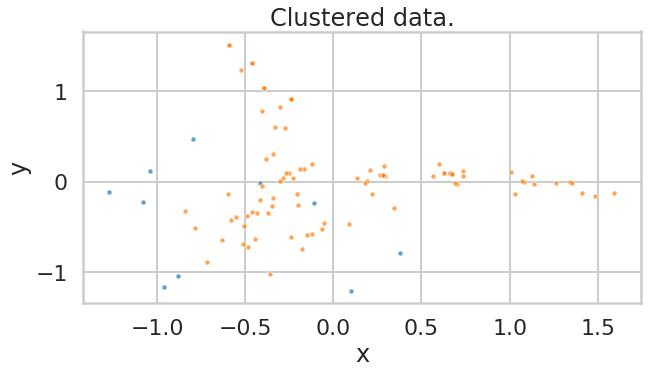

Number of clusters found: 2
Silhouette score: 0.180204


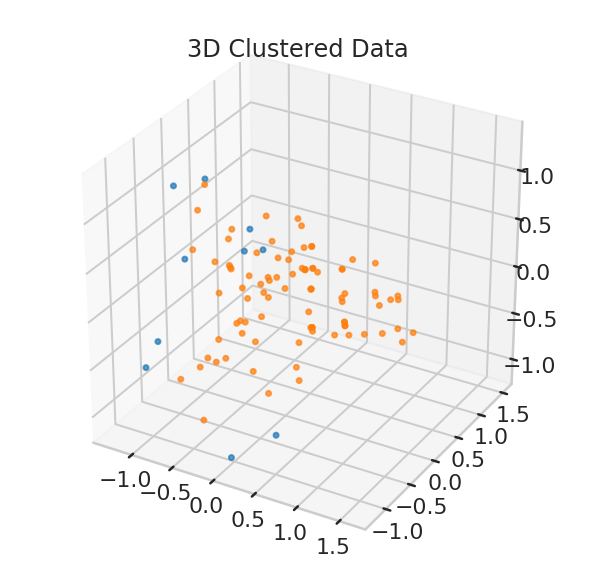

Number of clusters found: 2
Silhouette score: 0.180204


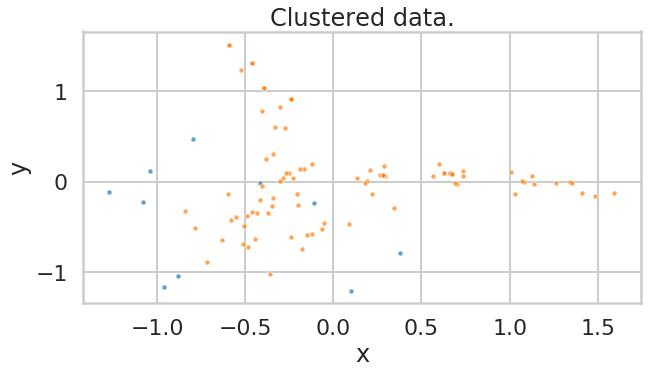

Number of clusters found: 2
Silhouette score: 0.180204


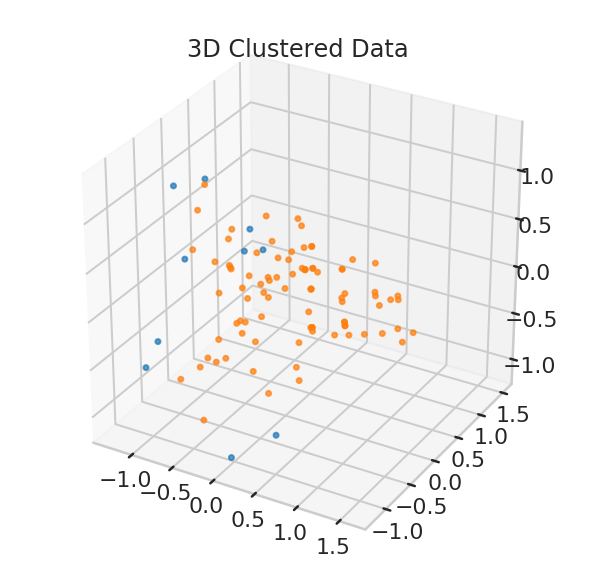

In [26]:
from sklearn.cluster import DBSCAN

for i in np.arange(1., 2, 0.1):
  db = DBSCAN(eps=i)
  db.fit(x_cols)
  plot_cluster(db, x_cols)
  plot_cluster_3d(db, x_cols)

Affinity Propogation is completely unsupervised. With the default values for this algrithm, it tends to overfit.


Agglormarative looked to give us the best clustiner. It ended up giving me the highest silhouette score for a cluster of 6 although if you look at the graph in 2D there is a fair amount of overlapt between 3 or more clusters in the lower left quadrant.  However in 3D, those clusters don't look so bad as the red cluster seems to be along the bottom of the z axis and the purple seems to be in a vertical plain along the z axis at around y == -1

Results for this algorithm is similar to KMeans which would make sense because both strategies are similar however, Agglormarative is a bottom up approach rather than top down approach meaning that each point starts as it's own cluster and we merge clusters based on distance whereas kMeans, we start at x cluster and we redistribute the points into different clusters until we have optimal loss


Spectral uses eigenvalues to determine where to cut off edges between nearest neighbors and looks from jump in eigenvalues to cut off clusters. Since most of our points are closely clustered, there probably are huge jumps in eigenvalues that would be easy for the algorithm to determine where to cut edges to create clusters

DBSCAN is a somewhat unsupervised method where it finds the optimal number of clusters based on distance of point. You can see from our 2D and 3D plots that points are all relatively close together - perhaps this is why DBSCAN did not do well and as we increase the distance, it started clustering down to 2 clusters looks like we ended up 1 big cluster and the 2nd cluster container outliers




